In [1]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix
    
r = session.query(Reactions).all()


2023-06-20 22:38:39,332 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-20 22:38:39,332 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("reactions")
2023-06-20 22:38:39,332 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-20 22:38:39,333 INFO sqlalchemy.engine.Engine COMMIT


/var/folders/8k/w__0g4xs7rj0xv7hk3dqm71w0000gn/T/ipykernel_29899/1566840691.py:52: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = session.query(Reactions).all()


In [2]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

class_reagents = {k:[] for k in reagent_classes}
multipliers = [1, 1, 1, 1, 1]
yields = []
index_split_by_class = {k:[] for k in reagent_classes}
rxnfps = []
yield_group = []
concat_fp = []
diff_fp = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    # print(k.reaction_name)
    if k.output_value > 100:
        continue
        
    ccfp = np.zeros(0)
    for j in reagent_classes:
        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)
        if sm not in class_reagents[j]:
            class_reagents[j].append(sm)

        index_split_by_class[j].append(class_reagents[j].index(sm))
        
        cfp = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), cfp)
        ccfp = np.concatenate((ccfp, cfp), axis=0)
    
    
    pmol = Chem.MolFromSmiles(k.product)
    pfp = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(pmol, 4), pfp)

    emol = Chem.MolFromSmiles(k.product)
    efp = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(emol, 4), efp)

    nmol = Chem.MolFromSmiles(k.product)
    nfp = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(nmol, 4), nfp)

    diff_fp.append(pfp - (nfp + efp))
    
    n = k.group
    if k.output_value == 0:
        yield_group.append(0)
    elif k.output_value < 33:
        yield_group.append(1)
    elif k.output_value < 66:
        yield_group.append(2)
    else:
        yield_group.append(3)

    yields.append(float(k.output_value))
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    concat_fp.append(ccfp)

In [3]:
print(len(diff_fp))

2569


In [4]:
from sklearn.manifold import TSNE

X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1, random_state=1, perplexity=20).fit_transform(rxnfps)
X_TSNE_CFP = TSNE(n_components=2, n_jobs=-1, random_state=1, perplexity=20).fit_transform(concat_fp)
X_TSNE_DFP = TSNE(n_components=2, n_jobs=-1, random_state=1, perplexity=20).fit_transform(diff_fp)


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne

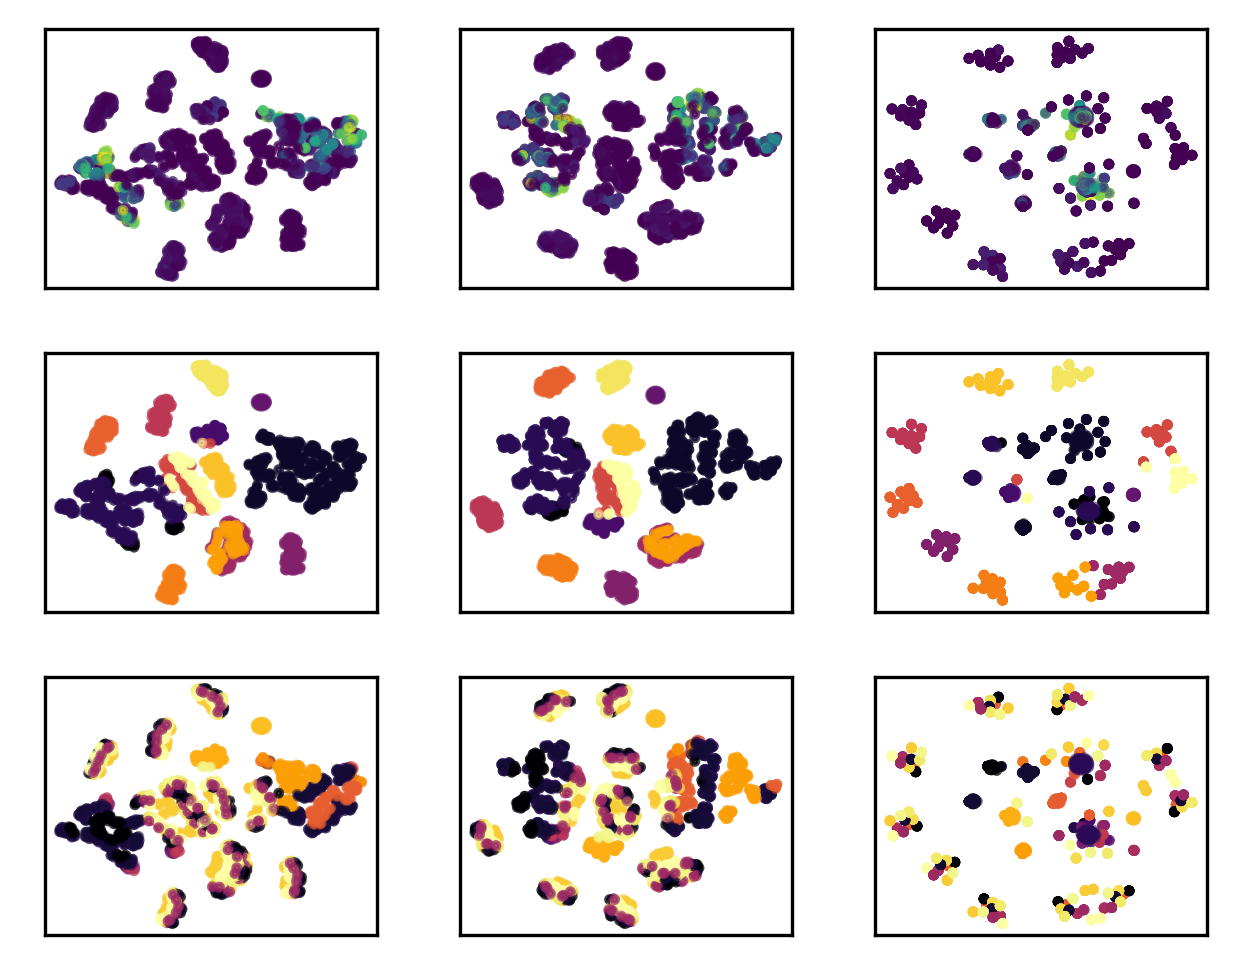

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,3, figsize=(5,4), dpi=300)
ax[0][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

ax[0][1].scatter(X_TSNE_CFP[:,0], X_TSNE_CFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[0][2].scatter(X_TSNE_DFP[:,0], X_TSNE_DFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][2].set_xticks([])
ax[0][2].set_yticks([])

ax[1][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][0].set_xticks([])
ax[1][0].set_yticks([])

ax[1][1].scatter(X_TSNE_CFP[:,0], X_TSNE_CFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])

ax[1][2].scatter(X_TSNE_DFP[:,0], X_TSNE_DFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][2].set_xticks([])
ax[1][2].set_yticks([])

ax[2][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][0].set_xticks([])
ax[2][0].set_yticks([])

ax[2][1].scatter(X_TSNE_CFP[:,0], X_TSNE_CFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][1].set_xticks([])
ax[2][1].set_yticks([])

ax[2][2].scatter(X_TSNE_DFP[:,0], X_TSNE_DFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][2].set_xticks([])
ax[2][2].set_yticks([])

plt.subplots_adjust(wspace=.25, hspace=.25)

plt.savefig('si8a.png', dpi=300, bbox_inches='tight',pad_inches=0.01)

In [9]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

class_reagents = {k:[] for k in reagent_classes}
multipliers = [3, 1, 1, 1, 1]
yields = []
index_split_by_class = {k:[] for k in reagent_classes}
rxnfps = []
yield_group = []
concat_fp = []
diff_fp = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    # print(k.reaction_name)
    if k.output_value > 100:
        continue
        
    ccfp = np.zeros(0)
    for j in reagent_classes:
        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)
        if sm not in class_reagents[j]:
            class_reagents[j].append(sm)

        index_split_by_class[j].append(class_reagents[j].index(sm))
        
        cfp = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), cfp)
        if j == "electrophile":
            cfp = cfp * 3
        ccfp = np.concatenate((ccfp, cfp), axis=0)
    
    
    pmol = Chem.MolFromSmiles(k.product)
    pfp = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(pmol, 4), pfp)

    emol = Chem.MolFromSmiles(k.product)
    efp = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(emol, 4), efp)

    nmol = Chem.MolFromSmiles(k.product)
    nfp = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(nmol, 4), nfp)

    diff_fp.append(pfp - (nfp + efp*3))
    
    n = k.group
    if k.output_value == 0:
        yield_group.append(0)
    elif k.output_value < 33:
        yield_group.append(1)
    elif k.output_value < 66:
        yield_group.append(2)
    else:
        yield_group.append(3)

    yields.append(float(k.output_value))
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    concat_fp.append(ccfp)

In [10]:
from sklearn.manifold import TSNE

X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1, random_state=1, perplexity=20).fit_transform(rxnfps)
X_TSNE_CFP = TSNE(n_components=2, n_jobs=-1, random_state=1, perplexity=20).fit_transform(concat_fp)
X_TSNE_DFP = TSNE(n_components=2, n_jobs=-1, random_state=1, perplexity=20).fit_transform(diff_fp)


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne

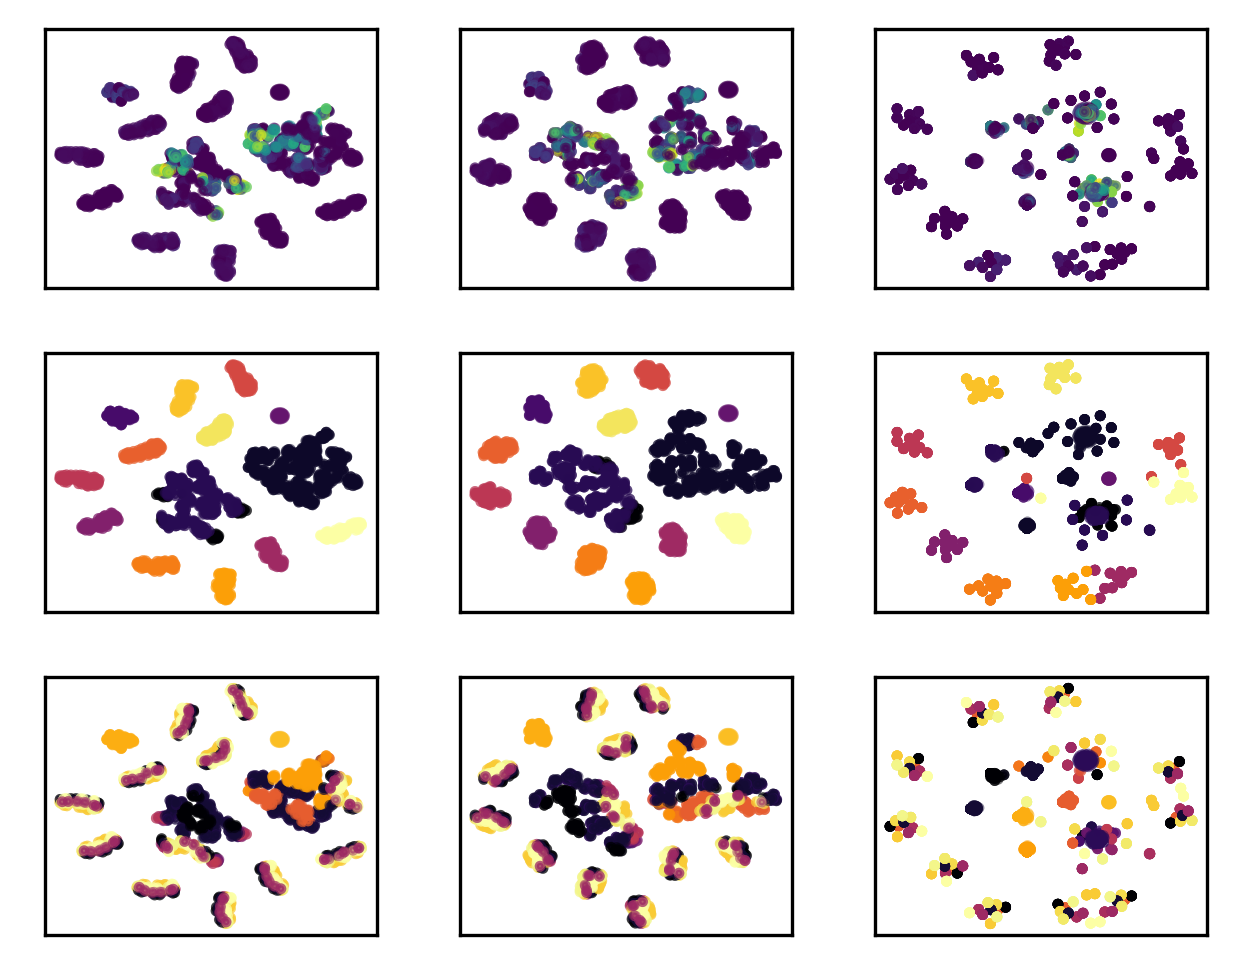

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,3, figsize=(5,4), dpi=300)
ax[0][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

ax[0][1].scatter(X_TSNE_CFP[:,0], X_TSNE_CFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[0][2].scatter(X_TSNE_DFP[:,0], X_TSNE_DFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][2].set_xticks([])
ax[0][2].set_yticks([])

ax[1][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][0].set_xticks([])
ax[1][0].set_yticks([])

ax[1][1].scatter(X_TSNE_CFP[:,0], X_TSNE_CFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])

ax[1][2].scatter(X_TSNE_DFP[:,0], X_TSNE_DFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][2].set_xticks([])
ax[1][2].set_yticks([])

ax[2][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][0].set_xticks([])
ax[2][0].set_yticks([])

ax[2][1].scatter(X_TSNE_CFP[:,0], X_TSNE_CFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][1].set_xticks([])
ax[2][1].set_yticks([])

ax[2][2].scatter(X_TSNE_DFP[:,0], X_TSNE_DFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][2].set_xticks([])
ax[2][2].set_yticks([])

plt.subplots_adjust(wspace=.25, hspace=.25)

plt.savefig('si8b.png', dpi=300, bbox_inches='tight',pad_inches=0.01)